# Part 01 - Portfolio Construction

In this notebook we will be constructing a mean reverting portfolio of assets. We will construct a synthetic mean reverting price series consisting of weighted combinations of a basket of assets.

To construct such a portfolio we will make use of the of the open source package [Bayesian-Optimization](https://github.com/fmfn/BayesianOptimization) to perform global optimization using [Gaussian processes](https://en.wikipedia.org/wiki/Bayesian_optimization). We will be optimizing the [Hurst exponent](https://en.wikipedia.org/wiki/Hurst_exponent) in one example, and the [ADF test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) in the second example.

As a third approach we will also explore using [the Johansen test](https://en.wikipedia.org/wiki/Johansen_test) which tests for cointegration for multiple time series and also determines the proper hedge ratio for the mean reverting portfolio.

### Motivation

If we can construct a portfolio or basket of assets that has the characteristics of a mean reverting price series, then we can attempt trade this mean reverting price series by entering a counter trend trade on the entire potfolio whenever the value has moved statistically far from the mean.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
from bayes_opt import BayesianOptimization
from sklearn import linear_model
import statsmodels.tsa.stattools as ts # this causes a warning with pandas
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [2]:
style.use('seaborn-whitegrid')

## Data

For the purpose of this project we will use cryptocurrency data from Poloniex. I have selected the pairs currently available for margin trading on the Poloniex exchange because the ability to short an asset will be necessary in the strategy resulting from this study.

In [94]:
with pd.HDFStore('polo_closing_5m_margin.h5') as store:
    closes = store['closes']

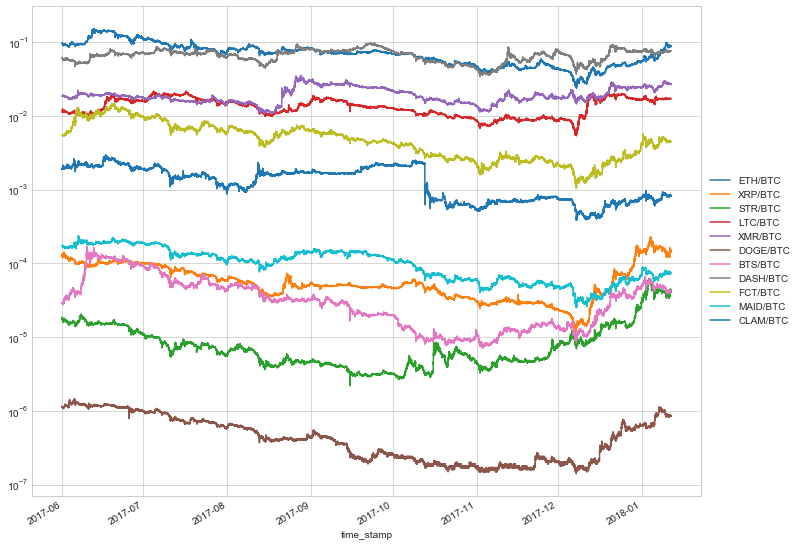

In [4]:
closes.plot(figsize=(12,10), logy=True).legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Hurst Optimization

### Hurst Calculation

In [5]:
def hurst(series):
    """
    Returns the Hurst Exponent of the time series (series)
    """

    # Check for pandas
    if type(series).__module__.split('.')[0] == pd.__name__:
        if len(series.shape) > 1:
                series = series.values[:,0]
        else:
                series = series.values
    elif not type(series).__module__.split('.')[0] == np.__name__:
        raise ValueError("""Series must by either pandas object or
                            numpy nx1 array. The series found is of
                            type {0} with name {1}""".strip().format(type(series),
                                                                     type(series).__module__))

    # Create range of lag values
    lags = np.arange(2, 100)

    # Calculate the array of variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(series[lag:], series[:-lag]))) for lag in lags]

    # use linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    return poly[0]*2

In [6]:
def generate_linear_combination(weights, data):
    if len(weights) != data.shape[1]:
        raise ValueError('The number of weights must match the number of assets.')
    weights = np.asanyarray(weights)
    return data.multiply(weights).sum(axis=1)

In [7]:
def opt_func(weights, data, func):
    if len(weights) != data.shape[1]:
        raise ValueError('The number of weights must match the number of assets.')
    agg_series = generate_linear_combination(weights, data)
    return func(agg_series)

#### Testing The Hurst Calculation
We can test our functions by using a value of 1 for all weights. We should expect that this would produce a price series with near random behaviour resulting in a Hurst exponent near 0.5.

In [8]:
opt_func(np.ones(closes.shape[1]), closes, hurst)

0.4991169063645621

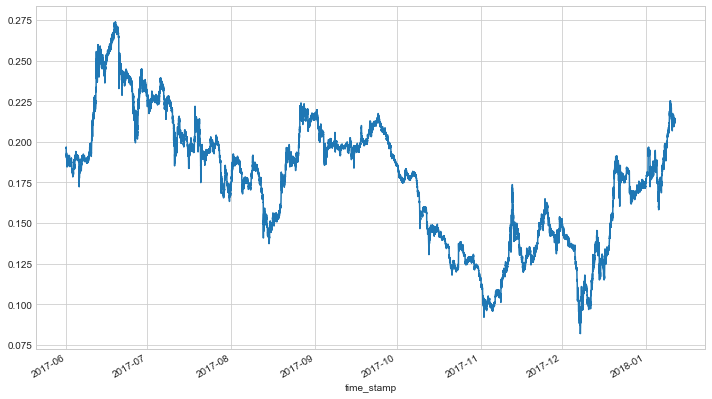

In [9]:
generate_linear_combination(np.ones(closes.shape[1]), closes).plot(figsize=(12,7));

### Bayesian Optimization

I want to take a sample of the data to run on.

In [10]:
closes.shape

(89253, 11)

In [11]:
sample_size = int(closes.shape[0] / 50)

In [12]:
closes_sample = closes.iloc[:sample_size,:]

For the optimization we will need to first estabolish upper and lower bounds. I will take a guess using a beta calculated between the price series of the two pairs with the largets difference in price.

In [13]:
sorted_pairs = closes.iloc[0,:].sort_values().index
max_pair = sorted_pairs[-1]
min_pair = sorted_pairs[0]

In [14]:
regr = linear_model.LinearRegression()
regr.fit(closes.loc[:,min_pair].values[:, np.newaxis], closes.loc[:,max_pair].values[:, np.newaxis])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
beta = regr.coef_[0][0]

In [16]:
beta

67523.58375860011

I am going to use an upper bound of $0.001 * beta$ and a lower bound of $-0.001 * beta$. Since we are using a parameter for each asset, the actual max and min bounds don't matter because we can scale them arbitrarilly.

We also need to be able to construct a **lambda** function with a **dynamic number of parameters** based on the number of pairs that we have.

In [18]:
list(closes.columns)

['ETH/BTC',
 'XRP/BTC',
 'STR/BTC',
 'LTC/BTC',
 'XMR/BTC',
 'DOGE/BTC',
 'BTS/BTC',
 'DASH/BTC',
 'FCT/BTC',
 'MAID/BTC',
 'CLAM/BTC']

In [58]:
def run_optimization(data, func):
    # we will use `eval()` to generate a dynamic lambda function
    # this is a temporary solution, I don't like using eval here
    f = lambda x: opt_func(x, data, func)
    s = "lambda "
    beta_vars = [val.replace('/','_') for val in data.columns]
    joined_beta_vars = ','.join(beta_vars)
    s += joined_beta_vars
    # we will multipy by (-1) because we will have to maximize the func
    # the hurst exponent [0,1] where 0 is mean reverting and 1 is trending
    s += ': (-1)*f([{0}])'.format(joined_beta_vars)
    final_opt_func = eval(s,{'f':f})  # this process should be replaced by a better dynamic lambda option
    
    # generate max and min vals # this part is not critical, we could simply use 1.0 and -1.0
    sorted_pairs = data.iloc[0,:].sort_values().index
    max_pair = sorted_pairs[-1]
    min_pair = sorted_pairs[0]
    regr = linear_model.LinearRegression()
    regr.fit(data.loc[:,min_pair].values[:, np.newaxis], data.loc[:,max_pair].values[:, np.newaxis])
    beta = regr.coef_[0][0]
    
    beta_max = 0.001*beta
    beta_min = -0.001*beta
    print('Max beta used is: ', beta_max)
    print('Min beta used is: ', beta_min)
    
#     beta_max = 1.0
#     beta_min = -1.0
    
    # set up the optimization
    bo = BayesianOptimization(final_opt_func, {b:(beta_min, beta_max) for b in beta_vars})
    bo.maximize(init_points=20, n_iter=20, acq='ucb')
    return bo

In [20]:
def get_mr_series(bo, data):
    max_params = bo.res['max']['max_params']
    params_list = []
    for val in data.columns:
        params_list.append(max_params[val.replace('/','_')])
    return data.multiply(params_list).sum(axis=1)

In [21]:
def plot_bo_result(bo, data, mean_period=50):
    mr = get_mr_series(bo, data)
    mr.plot(figsize=(10,7))
    mr.rolling(mean_period).mean().plot()

In [22]:
bo = run_optimization(closes, hurst)

Max beta used is:  67.52358375860011
Min beta used is:  -67.52358375860011
Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   BTS_BTC |   CLAM_BTC |   DASH_BTC |   DOGE_BTC |   ETH_BTC |   FCT_BTC |   LTC_BTC |   MAID_BTC |   STR_BTC |   XMR_BTC |   XRP_BTC | 
    1 | 00m00s |   -0.47791 |  -34.4329 |   -55.3434 |   -46.3843 |   -18.0765 |  -51.5264 |  -65.3182 |   49.8645 |    -3.7398 |  -65.5085 |   22.9633 |   62.9881 | 
    2 | 00m00s |   -0.44683 |   34.8014 |   -54.1197 |    18.5511 |    -2.4264 |   30.3007 |  -49.9769 |   53.6808 |     5.8633 |   47.1952 |  -57.9652 |    0.9435 | 
    3 | 00m00s |   -0.47994 |   35.0126 |    65.1957 |    51.0565 |   -65.2911 |   43.4945 |  -50.3012 |  -38.2411 |    53.3611 |  -33.4263 |   29.1407 |   23.4461 | 
    4 | 00m00s |   -0.49434 |   21.8431 |   -63.1574 |   -18.8015 |    26.21

/Users/kennethpotts/anaconda3/envs/ccxt_new/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.7289336e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   35 | 00m15s |   -0.42260 |   42.7669 |   -51.2527 |    46.0813 |   -62.2046 |  -60.9680 |   59.7041 |   62.5712 |    64.1938 |  -67.3902 |  -67.3659 |  -19.6805 | 
   36 | 00m15s |   -0.41740 |   66.5354 |   -51.6991 |   -57.6600 |    12.3437 |   62.4528 |  -63.6230 |  -67.1721 |   -20.1983 |   67.0531 |   47.4972 |   35.7819 | 
   37 | 00m14s |   -0.48269 |   66.8093 |   -58.7019 |    57.8683 |    67.5121 |   51.9470 |  -64.1728 |  -37.0981 |   -61.7857 |   56.6909 |   60.1960 |   66.3850 | 
   38 | 00m14s |   -0.41712 |  -63.5785 |   -31.5840 |    66.8142 |   -50.7746 |  -56.4811 |   27.4699 |  -52.7674 |   -61.8897 |   49.0837 |   54.1635 |   62.2287 | 
   39 | 00m13s |   -0.42279 |   -3.9141 |    58.1614 |    67.5236 |    67.5236 |  -67.5236 |   67.5236 |    3.0410 |    67.5236 |  -67.5236 |   67.5236 |  -52.7062 | 
   40 | 00m13s |   -0.41260 |  -66.7905 |   -62.5451 |   -63.0177 |   -48.4203 |   61.8314 |  -54.6773 |   67.1890 |    59.9503 |   41.1643 |  -17.3850 |  -63.4534 |

In [23]:
bo.res['max']

{'max_params': {'BTS_BTC': -54.667847491479115,
  'CLAM_BTC': -38.22726820625205,
  'DASH_BTC': 67.44045112217354,
  'DOGE_BTC': 67.13516166240005,
  'ETH_BTC': -48.58513556771804,
  'FCT_BTC': 57.663665071967316,
  'LTC_BTC': 45.778777447563314,
  'MAID_BTC': 62.230360244086555,
  'STR_BTC': -54.960593551182995,
  'XMR_BTC': -66.20644687829682,
  'XRP_BTC': 67.41719090490254},
 'max_val': -0.410772116511415}

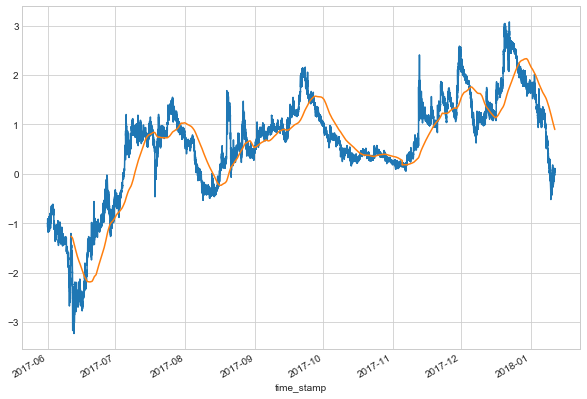

In [24]:
plot_bo_result(bo, closes, mean_period=3000)

In [25]:
bo_sample = run_optimization(closes_sample, hurst)

Max beta used is:  8.291323460006328
Min beta used is:  -8.291323460006328
Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   BTS_BTC |   CLAM_BTC |   DASH_BTC |   DOGE_BTC |   ETH_BTC |   FCT_BTC |   LTC_BTC |   MAID_BTC |   STR_BTC |   XMR_BTC |   XRP_BTC | 
    1 | 00m00s |   -0.36157 |    6.5902 |    -4.9684 |     6.3758 |    -8.1302 |   -5.9385 |   -5.0783 |    6.7575 |     4.4817 |   -4.0062 |   -3.5896 |    6.1386 | 
    2 | 00m00s |   -0.43029 |    6.9279 |     4.0012 |    -3.9765 |    -5.2842 |   -2.9508 |    2.8710 |   -2.6611 |     4.8226 |   -1.0455 |    1.0071 |    2.1520 | 
    3 | 00m00s |   -0.36932 |   -0.6121 |    -2.2612 |     7.3383 |     2.3857 |    0.3906 |   -0.7277 |   -8.2096 |     7.0007 |    5.1274 |   -3.2894 |   -5.0318 | 
    4 | 00m00s |   -0.41240 |    0.3260 |    -2.1643 |    -4.5959 |     3.66

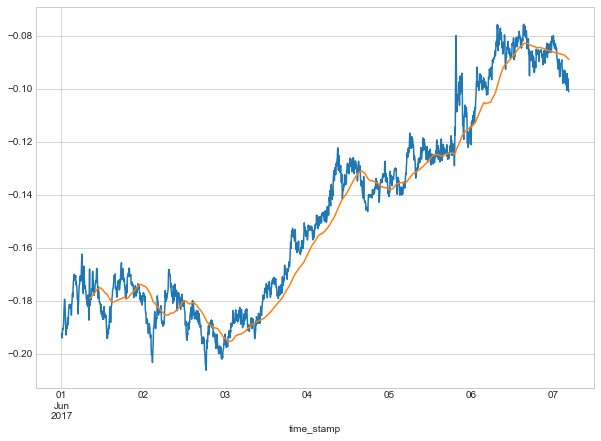

In [26]:
plot_bo_result(bo_sample, closes_sample, mean_period=100)

In [27]:
bo_sample.res['max']

{'max_params': {'BTS_BTC': 3.2562543812152605,
  'CLAM_BTC': -4.472020069678338,
  'DASH_BTC': -7.8575866738817925,
  'DOGE_BTC': 0.33233679927269577,
  'ETH_BTC': 3.5336710176080093,
  'FCT_BTC': 6.89292282543218,
  'LTC_BTC': -2.6781456887625996,
  'MAID_BTC': -2.7939070239753816,
  'STR_BTC': 0.5773498610789716,
  'XMR_BTC': -2.555981610978333,
  'XRP_BTC': -2.4958382401018593},
 'max_val': -0.3216614402777719}

## ADF Optimization

### ADF Calculation
We can take advantage of `statsmodels` `adfuller` ADF implementation. I will simply just wrap it up nicely. We can either optimize for the negative p-value or the negative test statistic. Both should yield the same effect. Here I will choose the p-value to make it a little more interpretable on it's own, although optimizing for a p-value is in general a bad practice.

In [28]:
def adf_for_opt(data):
    return ts.adfuller(data)[1]

#### Testing the ADF Test.
We can test our functions by using a value of 1 for all weights. We should expect that this would produce a price series with near random behaviour resulting in no rejection of the null hypothesis.

In [29]:
opt_func(np.ones(closes.shape[1]), closes, adf_for_opt)

0.6890499102959688

The p-value is insignificant.

### Bayesian Optimization for ADF

In [30]:
bo_sample_adf = run_optimization(closes_sample, adf_for_opt)

Max beta used is:  8.291323460006328
Min beta used is:  -8.291323460006328
Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   BTS_BTC |   CLAM_BTC |   DASH_BTC |   DOGE_BTC |   ETH_BTC |   FCT_BTC |   LTC_BTC |   MAID_BTC |   STR_BTC |   XMR_BTC |   XRP_BTC | 
    1 | 00m00s |   -0.33634 |    8.2009 |     4.8179 |    -5.4847 |    -3.4109 |    0.0085 |    1.3509 |    8.0580 |    -1.8126 |   -7.3045 |   -0.4836 |   -3.9295 | 
    2 | 00m00s |   -0.05422 |    0.4618 |    -0.4131 |     2.3135 |    -0.4851 |    7.1818 |    1.5830 |    3.4379 |    -7.0991 |   -0.9694 |    4.1184 |   -6.3652 | 
    3 | 00m00s |   -0.05980 |    1.1546 |     7.8766 |    -6.8240 |    -7.9041 |   -8.0821 |    3.5092 |    5.6011 |     5.5437 |    4.2318 |   -2.5854 |   -2.7342 | 
    4 | 00m00s |   -0.39938 |   -7.6282 |     7.6188 |    -0.5302 |    -6.55

In [31]:
bo_sample_adf.res['max']

{'max_params': {'BTS_BTC': 6.008797575605339,
  'CLAM_BTC': 3.781189187132922,
  'DASH_BTC': -4.034493937943086,
  'DOGE_BTC': -6.574640735373403,
  'ETH_BTC': -2.2080616883042596,
  'FCT_BTC': -6.1114917130414526,
  'LTC_BTC': 1.7357296305038012,
  'MAID_BTC': 3.6788900677258116,
  'STR_BTC': -4.493532049959048,
  'XMR_BTC': -1.5571144301984257,
  'XRP_BTC': -5.418194649492349},
 'max_val': -0.011566401051325132}

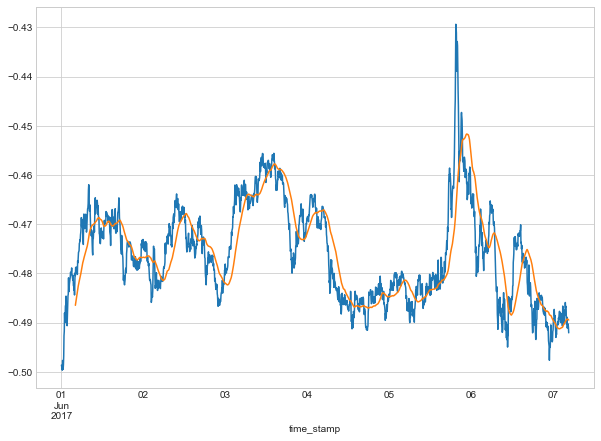

In [32]:
plot_bo_result(bo_sample_adf, closes_sample)

#### Observations

Just from looking at the charts, the mean reverting series generated from optimizing the ADF looks like it would be better to trade.

### Out of Sample Visualization

In [33]:
closes_second_sample = closes.iloc[sample_size:2*sample_size,:]

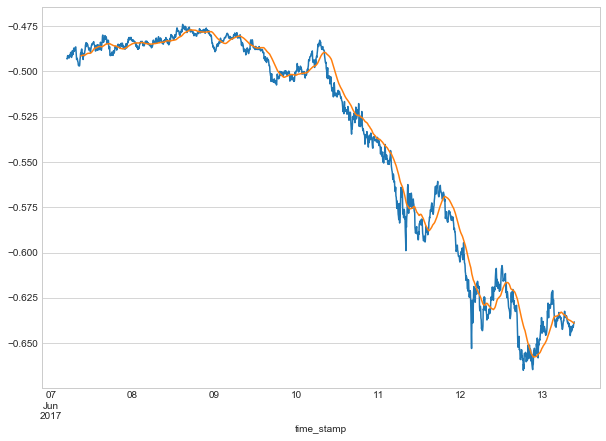

In [34]:
plot_bo_result(bo_sample_adf, closes_second_sample)

In [35]:
ts.adfuller(get_mr_series(bo_sample_adf, closes_second_sample))

(0.41213340239942803,
 0.9819430598320278,
 16,
 1768,
 {'1%': -3.434054083572257,
  '10%': -2.567641034389652,
  '5%': -2.8631761468358614},
 -16624.032861086493)

It appears that the results are not significan out of sample, although the first half of the series does appear to be mean reverting, but we're already in the scary realm of datamining.

In [36]:
ts.adfuller(get_mr_series(bo_sample_adf, closes_second_sample.iloc[:int(sample_size/2)]))

(-2.0031328961298365,
 0.2852011251626796,
 1,
 890,
 {'1%': -3.43771883253448,
  '10%': -2.568502085595253,
  '5%': -2.8647929301713977},
 -9436.536721428143)

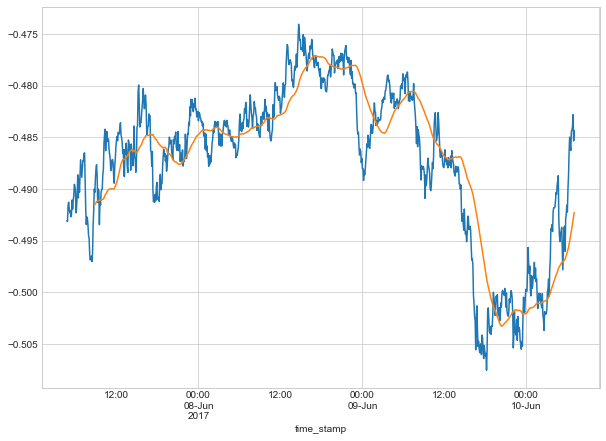

In [37]:
plot_bo_result(bo_sample_adf, closes_second_sample.iloc[:int(sample_size/2)])

We may need to tweak the parameters of the Gaussian Process model to make the model less sensitive and more robust for out of sample use. We may have found a close to minimal p-value, but not a robust linear combination.

### Observations

I used a significant amount of initial random guesses for these models which resulted in a lack confidence at the max/min values for the beta parameters. Much of the model optimization occured around the max/min values due to the high upper confidence bounds rather than optimizing for realistic paramters. In the end most of the optimal parameters came directly from the initial random guesses. I will have to fine tune these models in the future.

## Johansen Test

Here we will construct a mean reverting portfolio by finding optimal weights using the Johansen Test. I am referencing [this notebook](http://nbviewer.jupyter.org/github/mapsa/seminario-doc-2014/blob/master/cointegration-example.ipynb) for the proper use of the statsmodels johansen test.

In [81]:
def get_johansen(y, p):
    """
    Get the cointegration vectors at 95% level of significance
    given by the trace statistic test.
    """

    N, l = y.shape
    jres = coint_johansen(y, 0, p)
    trstat = jres.lr1                       # trace statistic
    tsignf = jres.cvt                       # critical values

    for i in range(l):
        if trstat[i] > tsignf[i, 1]:     # 0: 90%  1:95% 2: 99%
            r = i + 1
    jres.r = r
    jres.evecr = jres.evec[:, :r]

    return jres

In [98]:
p=1
jres=get_johansen(closes_sample,p)
print("There are ", jres.r, "cointegration vectors")
v1=jres.evecr[:,0]
v2=jres.evecr[:,1]
print(v1)
print(v2)
v3=jres.evec[:,2]  # v3 is not a cointegration vector

There are  2 cointegration vectors
[ 3.26547766e+02  1.14827155e+05 -5.14844745e+04 -4.45862164e+03
  2.26917710e+02  1.20969771e+07 -3.95651856e+05  1.52119823e+02
  4.25011233e+02 -7.57094339e+04  9.03401158e+03]
[-3.85858682e+01  2.39998188e+05 -2.74409177e+06 -1.28236925e+02
  1.30787813e+03  9.63710752e+06  7.75787796e+04  5.68973489e+02
  7.27615838e+02  2.12920398e+04 -4.26235428e+03]


### In Sample results

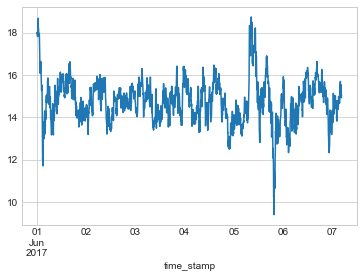

In [99]:
# If we apply vector v1 we get a I(0) time series
closes_sample.multiply(v1).sum(axis=1).plot()

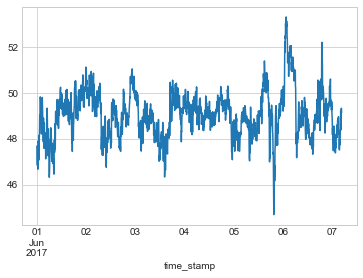

In [87]:
closes_sample.multiply(v2).sum(axis=1).plot()

### Out of Sample Results

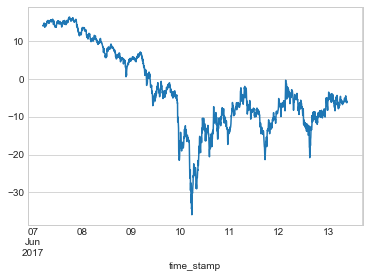

In [88]:
# If we apply vector v1 we get a I(0) time series
closes_second_sample.multiply(v1).sum(axis=1).plot()

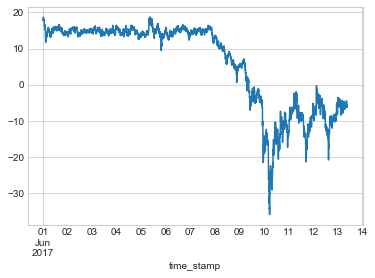

In [89]:
closes.iloc[:sample_size*2,:].multiply(v1).sum(axis=1).plot()

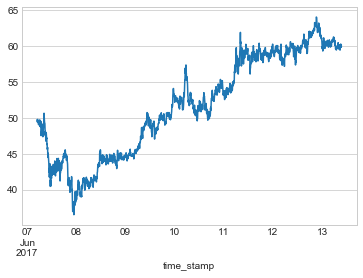

In [90]:
closes_second_sample.multiply(v2).sum(axis=1).plot()

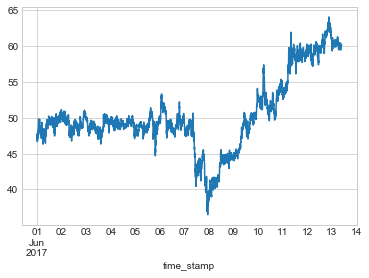

In [91]:
# If we apply vector v1 we get a I(0) time series
closes.iloc[:sample_size*2,:].multiply(v2).sum(axis=1).plot()

### Observations

These in sample plots seem almost too good to be true, and the suboptimal out of sample performance is no surprise. Overall, Johansen's test at first glance appears to be a better option because of it's speed at generating optimal hedge rations, as well as the general quality of the resulting mean reverting series (from a visual assessment).

## Conclusion

So far it appears that of the 3 options explored, the Johansen test yields the best results. It is also significantly faster than bayesian optimization.

## Next Step

In part 2 we will investigate if we can generate parameters that create a portfolio that is mean reverting out of sample using the Johansen test. Then we will use the portfolio price series to generate a predictive trading factor.
